Convert all ipynb files in repository in py files
jupyter nbconvert --to script *.ipynb

In [ ]:
# !pip install polars
# !pip install hurst
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import time
import warnings
import threading
import gc
from hurst import compute_Hc
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# warnings.filterwarnings("ignore")

In [ ]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [2]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [3]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
train.head(10)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [4]:
# dataframe dimensiosn
print(train.shape)

def pl_replace(df, replace_dict):
    return df.with_columns(pl.all().replace(replace_dict))

# For eeg data
def loadeeg(path):
    eeg = pl.read_parquet(path)
    # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    eeg = eeg.fill_null(0)
    eeg = eeg.fill_nan(0)
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pl.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    return (row,spectrogram,time)


(106800, 15)


# Compute time domain and frequency domain features

In [5]:
# Initialise a few things
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

train_grby = train.groupby("eeg_id")

In [ ]:
i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
print(fulleeg.shape)

n_comp = 10
pca = PCA(n_comp)
pcafit = pca.fit_transform(fulleeg)

pca.explained_variance_ratio_
ev = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,n_comp+1),ev, "b-")
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()
plt.close()

# selection 8 components for ~97.5% of the explained variance

In [6]:
def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out

In [7]:
class cThreadParams():
    def __init__(self):
        threading.Thread.__init__(self)
        self.next = 0
        self.pooled = 0

def run_file_opener(thread):
    file_id = train.eeg_id.unique()[min(count+1,17088)]
    path = f'{EEG_PATH}{file_id}.parquet'
    thread.next = loadeeg(path)
    # pooling

def pooling_channels(thread):
    thread.pooled = thread.next[["T3", "T4"]].clone()
    thread.pooled = thread.pooled.with_columns(
        FR = thread.next[["Fp2", "F4", "F8"]].mean(axis = 1),
        FL= thread.next[["Fp1", "F3", "F7"]].mean(axis = 1),
        BR = thread.next[["T5", "P3", "O1"]].mean(axis = 1),
        BL = thread.next[["P4", "O2", "T6"]].mean(axis = 1),
        CentrFB = thread.next[["Fz", "Cz", "Pz"]].mean(axis = 1),
        CentrLR = thread.next[["C3", "Cz", "C4"]].mean(axis = 1),
    )
    thread.pooled = thread.pooled.with_row_index(offset = 0)

In [8]:
class cFqFeat:
    def __init__(self):
        self.FFT = 0
        self.fq_bands = {"delta": [1*50,4*50-1], 
                         "theta": [4*50,8*50-1],
                         "alpha": [8*50,12*50-1],
                         "beta": [12*50,30*50-1],
                         "gamma": [30*50,100*50-1]}
        self.labels = ['delta','theta','alpha','beta','gamma']
        self.var_names = pd.Series([
            'T3_var_delta', 'T4_var_delta', 'FR_var_delta', 'FL_var_delta', 'BR_var_delta', 'BL_var_delta', 'CentrFB_var_delta', 'CentrLR_var_delta',
            'T3_var_theta', 'T4_var_theta', 'FR_var_theta', 'FL_var_theta', 'BR_var_theta', 'BL_var_theta', 'CentrFB_var_theta','CentrLR_var_theta',
            'T3_var_alpha', 'T4_var_alpha', 'FR_var_alpha', 'FL_var_alpha', 'BR_var_alpha', 'BL_var_alpha', 'CentrFB_var_alpha', 'CentrLR_var_alpha',
            'T3_var_beta', 'T4_var_beta', 'FR_var_beta', 'FL_var_beta','BR_var_beta', 'BL_var_beta', 'CentrFB_var_beta', 'CentrLR_var_beta',
            'T3_var_gamma', 'T4_var_gamma', 'FR_var_gamma', 'FL_var_gamma', 'BR_var_gamma', 'BL_var_gamma', 'CentrFB_var_gamma', 'CentrLR_var_gamma'])
        self.mean_names =  pd.Series([
            'T3_mean_delta', 'T4_mean_delta', 'FR_mean_delta', 'FL_mean_delta', 'BR_mean_delta', 'BL_mean_delta', 'CentrFB_mean_delta', 'CentrLR_mean_delta',
            'T3_mean_theta', 'T4_mean_theta', 'FR_mean_theta', 'FL_mean_theta', 'BR_mean_theta', 'BL_mean_theta', 'CentrFB_mean_theta','CentrLR_mean_theta',
            'T3_mean_alpha', 'T4_mean_alpha', 'FR_mean_alpha', 'FL_mean_alpha', 'BR_mean_alpha', 'BL_mean_alpha', 'CentrFB_mean_alpha', 'CentrLR_mean_alpha',
            'T3_mean_beta', 'T4_mean_beta', 'FR_mean_beta', 'FL_mean_beta','BR_mean_beta', 'BL_mean_beta', 'CentrFB_mean_beta', 'CentrLR_mean_beta',
            'T3_mean_gamma', 'T4_mean_gamma', 'FR_mean_gamma', 'FL_mean_gamma', 'BR_mean_gamma', 'BL_mean_gamma', 'CentrFB_mean_gamma', 'CentrLR_mean_gamma'])
        self.means = []
        self.vars = []


def extract_fq_feat(CLASS, eeg):
    CLASS.means = []
    CLASS.vars = []
    CLASS.FFT = np.abs(np.fft.fft(eeg[:,1:9].to_numpy(), axis = 0))
    for key, band in CLASS.fq_bands.items():
        mean_slice = np.mean(CLASS.FFT[band[0]:band[1],:], axis=0)
        var_slice = np.var(CLASS.FFT[band[0]:band[1],:], axis=0)
        CLASS.means.append(mean_slice)
        CLASS.vars.append(var_slice)
    CLASS.means = np.array(CLASS.means)
    CLASS.vars = np.array(CLASS.vars)
    CLASS.means = pl.DataFrame(CLASS.means.flatten("F")[np.newaxis,:])
    CLASS.vars = pl.DataFrame(CLASS.vars.flatten("F")[np.newaxis,:])
    CLASS.means.columns = CLASS.mean_names
    CLASS.vars.columns = CLASS.var_names
    
    return pl.concat([CLASS.means, CLASS.vars], how = "horizontal")


In [ ]:
channels_id = pd.Series(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
var = ['eeg_label_offset_seconds']

# + Cz alone for the central component without PCA
# 3 components per category + Cz + Ekg = 14 features. 

start = 0
n_parquet = 1700# 0:170 is ~1% of the dataset
Features_lf = pl.DataFrame()

# polars functions with columns, and makes it harder to replace values of a single row. It requires to always change the entire column, 
# and the python code to do so is heavy. To avoid it, I have created a predefined numpy array called "segment_col" with the values of 
# the "segments" column (-1,0,1). For each eeg dataset, I will simply add a new column containing all the predefined numpy values. 
# segment_col = np.zeros(len(time_eeg))
time_eeg = np.arange(-15, 15 + (1/200), (1/200))
segment_col = np.zeros(len(time_eeg))
mask = time_eeg < -5
segment_col[mask] = -1
mask = time_eeg > 5
segment_col[mask] = 1


t = time.time()

params = cThreadParams()
fq_feat = {0: cFqFeat(),
           1: cFqFeat(),
           2: cFqFeat()}

count = start-1
thr = threading.Thread(target=run_file_opener, args=(params,))
thr.start()
time.sleep(2)

fail = {}

for count, id in enumerate(train.eeg_id.unique()[start:n_parquet]):
    count += start
    # if count%10 == 0: print(count)
    
    thr.join()
    pooling_channels(params)
    pcaeeg = params.pooled.clone()
    print(count, pcaeeg.shape, int(time.time()-t))

    thr = threading.Thread(target=run_file_opener, args=(params,))
    thr.start()
    
    for i, offset in train_grby.get_group(id)[var].itertuples():
    
        eeg1 = pcaeeg.filter((pl.col("index") >= (offset)*200) & (pl.col("index") < (offset+10)*200)).clone()
        eeg2 = pcaeeg.filter((pl.col("index") >= (offset+20)*200) & (pl.col("index") < (offset+30)*200)).clone()
        eeg3 = pcaeeg.filter((pl.col("index") >= (offset+40)*200) & (pl.col("index") < (offset+50)*200)).clone()
        eeg = pl.concat([eeg1, eeg2, eeg3])
        eeg = eeg.with_columns(pl.Series("segments", segment_col[0:eeg.shape[0]]))
        
        if eeg.shape[0] > 5999:

            eeg_by_seg = eeg.group_by('segments') # for the time domain features
            
            # time domaine features
            features = eeg_by_seg.agg(pl.exclude("index").mean().name.suffix("_mean"),
                              pl.exclude("index").std().name.suffix("_std"),
                              pl.exclude("index").kurtosis().name.suffix("_kurt"),
                              pl.exclude("index").skew().name.suffix("_skew"),
                              (pl.exclude("index").max()-pl.exclude("row_nr").min()).name.suffix("_rng"),
                              pl.exclude("index").diff().abs().sum().name.suffix("_linelength"),
                              pl.exclude("index").pow(2).mean().pow(0.5).name.suffix("_rms"),
                              pl.exclude("index").apply(lambda x: hurst_fct(x)).name.suffix("_hurst"))

            list_eeg = [x for x in eeg_by_seg] # for the frequency domain features

            # frequency domain features3
            # I could not make the processing of start, during and after run in separate thread without python not freezing after a dozen iterations
            datafeat0 = extract_fq_feat(fq_feat[0], list_eeg[0][1])
            datafeat1 = extract_fq_feat(fq_feat[1], list_eeg[1][1])
            datafeat2 = extract_fq_feat(fq_feat[2], list_eeg[2][1])

            # combine time domain and frequency domain features, and add them to the long format dataframe.
            freq_feats = pl.concat([datafeat0, datafeat1, datafeat2])
            features = pl.concat([features, freq_feats], how = "horizontal")
            Features_lf = pl.concat([Features_lf, features])
            
    
        else: 
            if id not in fail.keys():
                fail[id] = []
            fail[id].append(offset)
            print(count, id, eeg.shape, offset)


print(f"Running time: {time.time()-t} s")


# by taking just the 10s of interests, I run 170 parquets files (1% of total) in 172s. 
# This means that it would take 17200 for the entire train set, thus 4h50. 

# with time domain and frequency domain features, I run 170 files in 668s. 
# This means that it would take 17200 for the entire train set, thus 18h35. 
# The test set contains only 2640 files, thus a prediction of 2h55 to extract the features from the test set.

# 4412 for 1700 files

In [ ]:
Features_lf.write_csv(f"{DIRECTORY}Features_lf_{start}-{n_parquet}.csv")
print(Features_lf.shape)

In [30]:
# from long format to wide format
segment_names = {-1:"_before",0:"_during",1:"_after"}

Features_wf = pl.DataFrame()

for i in [-1,0,1]:
    colnames = pl.Series(Features_lf.columns) + segment_names[i]
    copy_lf = Features_lf.clone().filter(pl.col('segments') == i)
    copy_lf.columns = colnames
    Features_wf = pl.concat([Features_wf, copy_lf], how = "horizontal")

#TD_Features_wf = TD_Features_wf.drop(["segments_BeforeAfter", "segments_During"])

Features_lf = Features_lf.drop(["segments"])
Features_wf = Features_wf.drop(["segments_before", "segments_during", "segments_after"])

In [32]:
# add the variables from the file train.csv to Features_wf (wf stands for wide format)
print(Features_wf.shape)
mask = train.eeg_id.isin(train.eeg_id.unique()[0:1700])
mask.value_counts()
colnames = Features_wf.columns
Features_wf = pd.DataFrame(Features_wf)
Features_wf.columns = colnames
Features_wf = pd.concat([train.loc[mask, :], Features_wf], axis = 1)
print(Features_wf.shape)

(11436, 432)
(11436, 447)


In [26]:
Features_wf.to_csv(f"{DIRECTORY}Features_wf_0-1700.csv", index = False)

In [12]:
vars = ["T3_mean_delta_before", "T3_mean_delta_during", "T3_mean_delta_after"]

Features_wf[vars]

,T3_mean_delta_before,T3_mean_delta_during,T3_mean_delta_after
0,665.022531,667.098857,800.936001
1,573.743621,784.779209,856.714117
2,584.907890,743.858740,871.136397
3,705.741648,823.496378,854.774743
4,721.523055,833.175658,739.255484
...,...,...,...
11431,984.425438,1105.672210,999.968565
11432,1108.271610,1021.520080,997.650285
11433,988.887526,961.750597,886.766638
11434,922.203886,1105.338864,984.632322


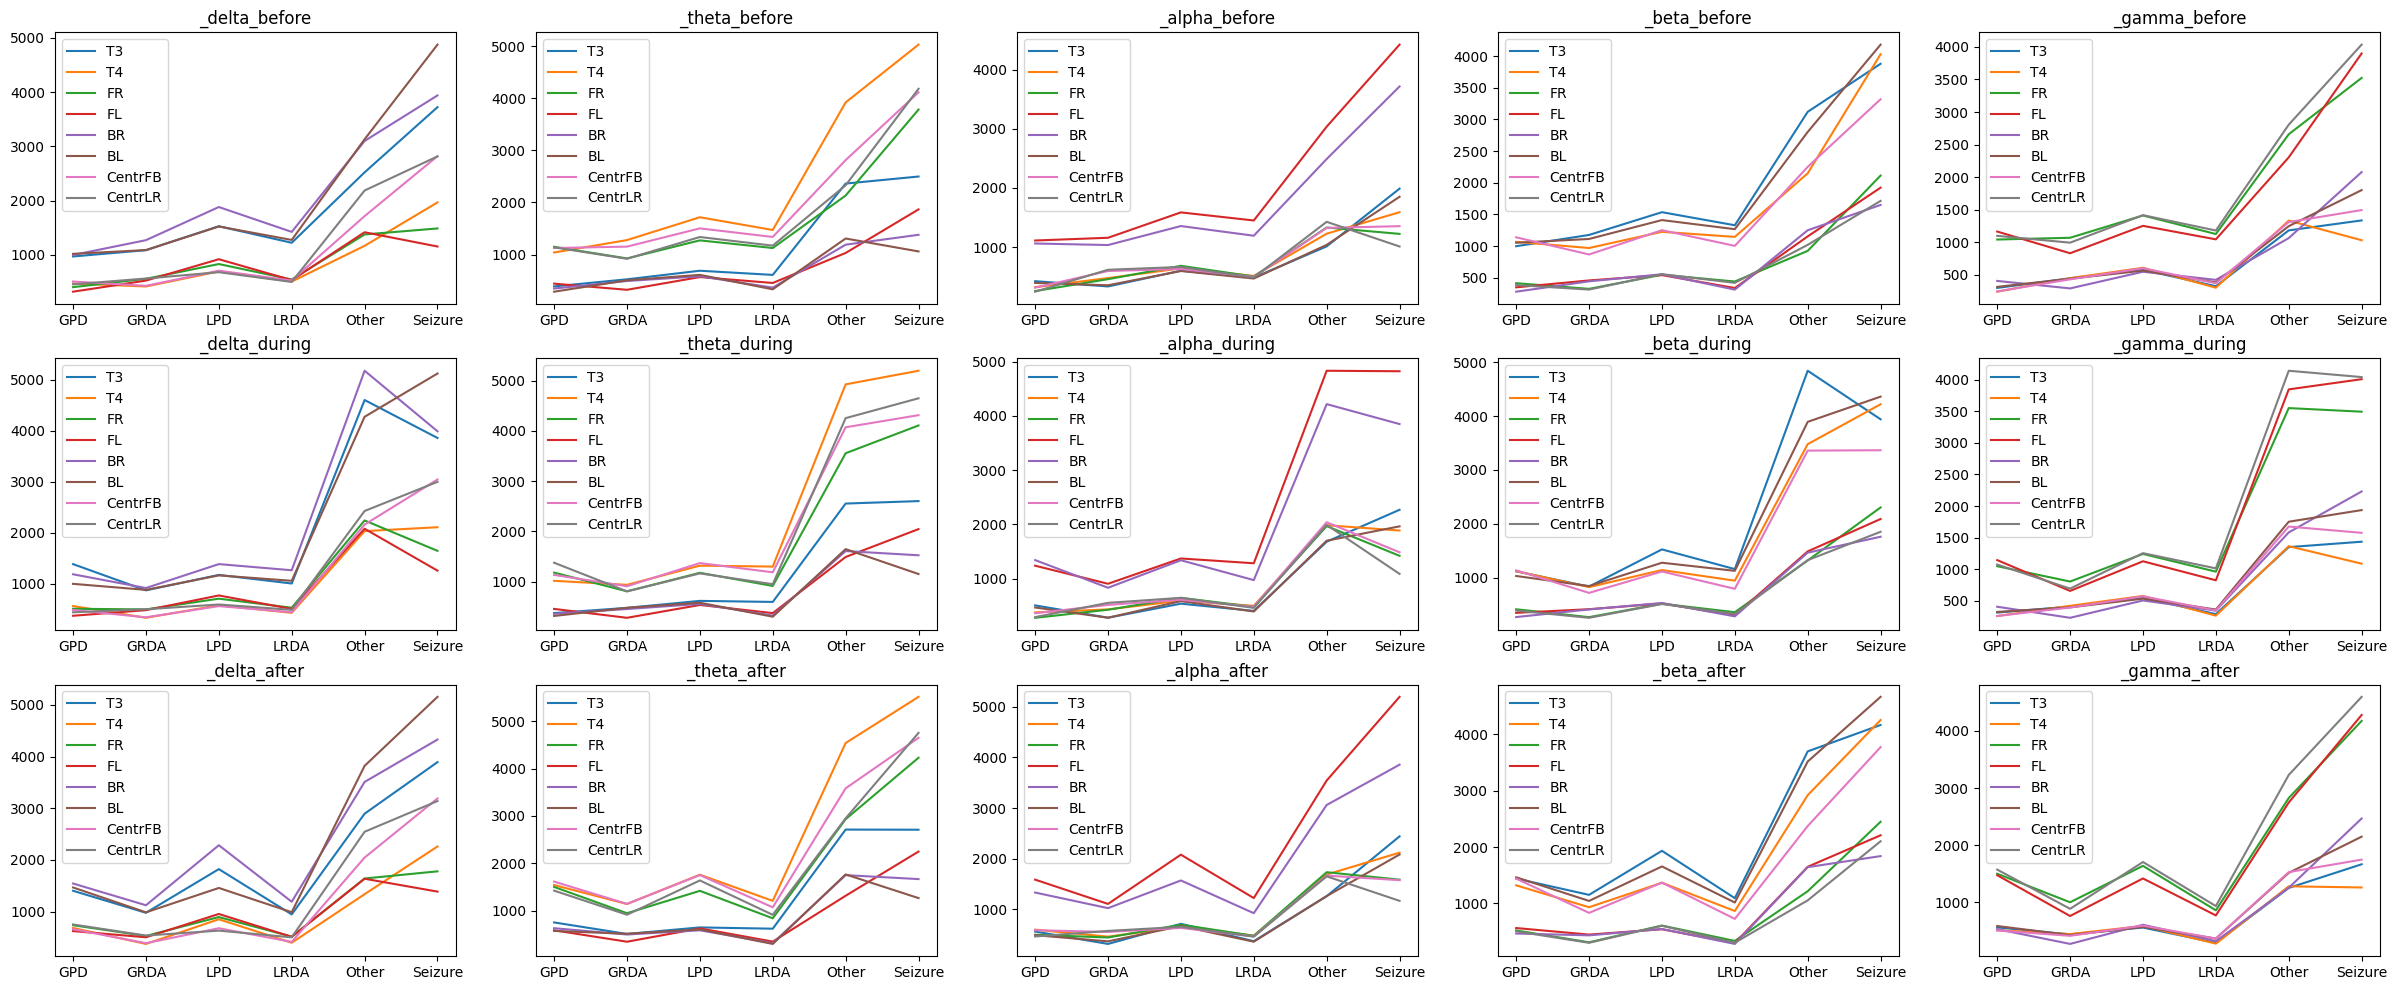

In [13]:
channels = ["T3", "T4", "FR", "FL", "BR", "BL", "CentrFB", "CentrLR"]
waves = ["_delta", "_theta", "_alpha", "_beta", "_gamma"]
segments = ["_before", "_during", "_after"]

# fig, ax = plt.subplots(1,5)
fig, ax = plt.subplots(3, 5, figsize=(30, 12))

grby = Features_wf.groupby("expert_consensus").mean()
xlab = grby.index

type = "_mean"
segment = "_during"
for i, seg in enumerate(segments):
    for j, wave in enumerate(waves):
        for chan in channels:
            ax[i,j].plot(xlab, grby[ chan + type + wave + seg ])
        ax[i,j].set_title( wave + seg )
        ax[i,j].legend(channels)
        
fig.set_size_inches(30, 12)
plt.savefig(f"{DIRECTORY}fq_byclass_1700.png")
plt.show()

In [ ]:
print(TD_Features_wf.shape)
TD_Features_wf

# Time frequency

In [ ]:
i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
fulleeg = fulleeg.drop("EKG")
print(fulleeg.columns)
print(fulleeg.shape)

time_eeg = np.arange(-25, 25+ (1/200), (1/200))
offset = int(train.loc[0, "eeg_label_offset_seconds"])
Hz = np.linspace(0,100,int((len(time_eeg)-1)/2+1))

pool = True

if pool == True:
    fulleeg = fulleeg.with_columns(
        frontleft = fulleeg[["F3", "Fp1", "F7"]].mean(axis = 1),
        frontright = fulleeg[["F4", "Fp2", "F8"]].mean(axis = 1),
        backleft = fulleeg[["O1", "P3", "T5"]].mean(axis = 1),
        backright = fulleeg[["O2", "P4", "T6"]].mean(axis = 1),
        centralfb = fulleeg[["Fz", "Cz", "Pz"]].mean(axis = 1),
        centrallr = fulleeg[["C3", "Cz", "C4"]].mean(axis = 1),
    )
    fulleeg = fulleeg[["frontleft", "frontright", "backleft", "backright", "centralfb", "centrallr", "T3", "T4"]].clone()


print(fulleeg.shape)

FFT = np.abs(np.fft.fft(fulleeg[offset*200:(offset+50)*200,:],axis = 0))[:len(Hz),:]

print(FFT.shape)

In [ ]:
fq_bands = {
"delta": [1,3],
"theta": [4,7],
"alpha": [8,12],
"beta": [13,30],
"gamma": [30,100],
}

xdat = []
xvar = []

for key, band in fq_bands.items():
    low = np.argmin((Hz-band[0])**2)
    hi = np.argmin((Hz-band[1])**2)

    print(FFT[low:hi,:])
    mean_slice = np.mean(FFT[low:hi,:], axis=0)
    var_slice = np.mean(FFT[low:hi,:], axis=0)

    xdat.append(mean_slice)
    xvar.append(var_slice)

xdat = np.array(xdat)
xvar = np.array(xvar)
print(xdat.shape)
print(xvar.shape)

# Plot the means/variances for all channels across the types of data
for chan in range(0, xdat.shape[1]):
    # print(xvar[:,chan])
    plt.plot(fq_bands.keys(),xvar[:,chan],label=f'Channel {chan}')

if pool: plt.legend()
plt.show()

# 0: "frontleft"
# 1: "frontright", 
# 2: "backleft", 
# 3: "backright",
# 4: "centralfb",
# 5: "centrallr", 
# 6: "T3",
# 7: "T4"]


In [ ]:
# SVD Entropy
# eeg_z = (eeg_seg-eeg_seg.mean())/eeg_seg.std()
#u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
# s = s/np.sum(s)
#TD_Features.loc[i, channels+"_SVDEn_"+ segment_names[seg]] = -(s*np.log(s)).sum()
# linelength['SVDEn' + seg] = SVDEn

# # Entropy
# add = eeg.sum()
# eegnorm = eeg/add
# entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
# entropy.index = entropy.index + '_entropy' + seg
# entropy = entropy.to_frame().transpose()

# Hurst Exponent
# hurst = []
#for idx,channel in enumerate(eeg.keys()):
#    h, c, data = compute_Hc(eeg[channel], simplified=True)
#    hurst.append(h)
# hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))

In [ ]:
print(Features_lf.shape)
print(Features_wf.shape)

In [ ]:
colnames = Features_lf.columns
pandas_data = Features_lf.to_numpy()
pandas_data = pd.DataFrame(pandas_data)
pandas_data.columns = colnames
pandas_data.tail()

In [ ]:
pandas_data.segments.value_counts()

In [ ]:
TD_Features_wf.tail(20)

In [ ]:
staticX2 = np.fft.fft(eeg['Fp1'])

staticHz = np.linspace(0,100,int(len(eeg['Fp1'])/2+1))

plt.plot(staticHz[1:],np.abs(staticX2[1:len(staticHz)]),'-.',label='FFT')
plt.show()

In [ ]:
# Explore what frequencies are in the spectrogram

allkeys = spectrogram.keys()
llkeys = []
for key in allkeys:
    if 'LL' in key:
        llkeys.append(key)
        
print(llkeys)

In [ ]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(eeg['Fp1'].to_numpy(),fs = 200,noverlap=10)
plt.pcolormesh(t,f,Sxx,shading='gouraud',vmin=0,vmax=10)
plt.ylabel('Frequency (a.u.)')
plt.xlabel('Time (a.u.)')
# plt.ylim([0,.005])
plt.show()


In [ ]:
spect = spectrogram.to_numpy()
plt.imshow(spect,vmin= 0, vmax = 10)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

principalComponents = pca.fit_transform(fulleeg)

# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [ ]:
# Try computing synchronisation
from scipy.signal import hilbert
from scipy.signal import iirfilter, filtfilt


# Define your frequency bands as a list of tuples (lowcut, highcut)
frequency_bands = [(1, 4), (4, 8), (8, 12), (12, 30), (30, 95)]  # Example bands in Hz
fs = 200.0  # Sampling frequency
order = 5  # Filter order - This is a trade off in terms of accuracy and time. The lower the faster, but less accurate/narrow
filters = []
# b, a = iirfilter(N=order, Wn=1, fs=fs, btype='lowpass', ftype='butter', output='ba')
# filters.append((b,a))

for lowcut, highcut in frequency_bands:
    b, a = iirfilter(N=order, Wn=[lowcut, highcut], fs=fs, btype='band', ftype='butter', output='ba')
    filters.append((b,a))    

    
# Function for synchronisation calculation
def compute_synch(filters,data):
    all_synch = np.empty((0, len(filters)))
    for i, (b, a) in enumerate(filters):
        filtered_signal = filtfilt(b, a, data, axis = 0)

        # Calculate the PLV matrix
        try:
            n_points, n_channels, n_reps = filtered_signal.shape # We can change this if we decide to compute on a 2D matrix
        except:
            n_points, n_channels = filtered_signal.shape
            n_reps = 1
            
        plv_matrix = np.zeros((n_channels, n_channels, n_reps))

        # Compute the analytical signal for each channel
        analytical_signals = hilbert(filtered_signal, axis=0)

        # Extract phases
        phases = np.angle(analytical_signals)
        if len(phases.shape) <= 2:
            phases = phases[:,:,np.newaxis]

        # Compute PLV for each pair of channels
        for i in range(n_channels):
            for j in range(i, n_channels):
                phase_diff = phases[:,i,:] - phases[:,j,:]
                plv = np.abs(np.mean(np.exp(1j * phase_diff),axis=0))
                plv_matrix[i, j,:] = plv # Upper triangle of Symmetric matrix
        synch = plv_matrix[np.triu_indices(n_channels,k = 1)].T
        if all_synch.shape[0] == 0:
            all_synch = synch
        else:
            all_synch = np.hstack((all_synch, synch))
        
    return all_synch

# Load data for synchronisation computation
Starttime = time.time()
labels = train.expert_consensus.unique()
numeegs = 30 # Number of datasets to load from each type
TD_data = {}
Synch_data = np.empty((0,171*len(filters)))
TD_ydata = []
Synch_ydat = np.empty((0,1))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)] # There were a few nans in there.
    chosen = np.random.choice(tempid,size=numeegs)
    
    for d in range(numeegs):
        path = f'{EEG_PATH}{int(chosen[d])}.parquet'
        fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
        offset = train.eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
        
        for offind, off in enumerate(offset):
            if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
                continue
            tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
            
        TD_data[int(chosen[d])] = tempdat
        TD_ydata.append(label)
        
        Synch_data = np.vstack((Synch_data,compute_synch(filters,tempdat)))
        templabs = np.array([label] * tempdat.shape[2])
        templabs = templabs[:,np.newaxis]
        Synch_ydat = np.vstack((Synch_ydat,templabs))
        
        

TD_keys = list(TD_data.keys())

print(f'Time Taken: {(time.time() - Starttime)/60} minutes for {len(Synch_ydat)} datasets')